# Lab 4: Effect of **data augmentation** on a *shallow, linear FCN*

Advanced Topics in Machine Learning -- Fall 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2024_Lab_04_FCN_Augmentation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#### High-level overview

In the *Lab* that follows, we will explore the effect of **data augmentation** on the structure of learned weights in a *neural network* model. As an example, we will consider a *shallow, linear FCN* (fully-connected network with just 1 layer and no non-linearities) that is trained on the MNIST *classification task*.

On a high level, you need to:
- Define and train a *shallow, linear FCN* on the MNIST dataset, using *training-set augmentation* by means of *random rotations*;
- Extract the learned weights from the trained model;
- Visualize the learned weights as *images* and comment on their structure.

The rest of the notebook will guide you through more detailed steps you need to follow.

#### Loading the datasets and defining augmentation strategies

Load the (training and test) *MNIST* datasets as we did in the previous lab, with the following meaningful differences:
- Apply random rotations to the dataset used for training, using a rotation range of $[0, 180]$ degrees.
- Apply normalization to both datasets, using a mean of $0.1307$ and a standard deviation of $0.3081$ (they are notable, pre-computed values for the MNIST **training** dataset);

**Hint**: look up the documentation for the `transforms.RandomRotation` and `transforms.Normalize` classes.

**Optional**: Visualize the augmented training dataset, to get a sense of the effect of the augmentation strategy.

In [77]:
# YOUR CODE HERE
from sklearn.datasets import load_digits
import torch
import torch.nn as nn
import torchvision.transforms.v2 as v2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math


#### Model definition and training

Define the model and train it on the classification task, as we did in the previous *Lab*. Use fixed-learning-rate *Stochastic Gradient Descent* (with no momentum) as the optimizer. Feel free to experiment with the other hyperparameters.

**Optional**: Plot the training loss as the training progresses. Show also test loss at the beginning and at the end of training.


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss:  0.02907770685851574


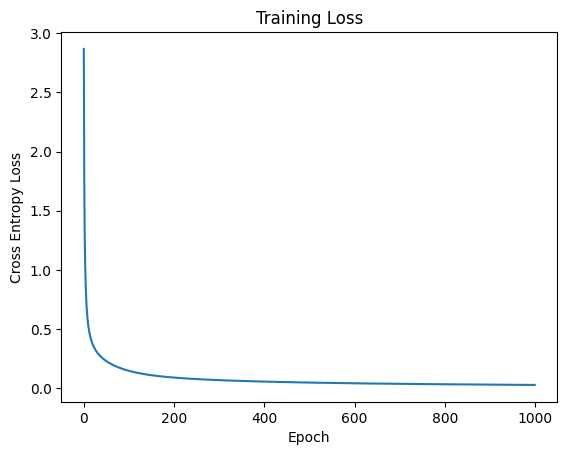

In [84]:
# YOUR CODE HERE
net_width = 10

class NeuralNet(nn.Module):
    def __init__(self, width, classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(64, width)
        self.head = nn.Linear(width, classes)
    
    def forward(self, x):
        return self.linear(x.flatten(1))
        x = self.linear(x.flatten(1))
        return self.head(x)


class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, rotate: bool = False):
        self.x, self.y = load_digits(return_X_y=True)
        self.rotate = rotate
        if self.rotate:
            self.transform = v2.Compose([
                v2.RandomRotation([-180, 180]),
                v2.Normalize(mean=[0.1307], std=[0.3081])
            ])
        else:
            self.transform = v2.Normalize(mean=[0.1307], std=[0.3081])
    
    def __getitem__(self, index):
        x = self.x[index].astype(np.float32).reshape(8, 8)
        
        if self.rotate:
            x = self.transform(x)
            
        y = self.y[index]
        return x,  y
    
    def __len__(self):
        return len(self.x)


model = NeuralNet(net_width, 10).train()
dataset = MNISTDataset(rotate=True)

lr = 0.01
n_epochs = 1000
batch_size = 512

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=lr,
)
criterion = nn.CrossEntropyLoss()
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size
)
all_loss = []
for i in tqdm(range(n_epochs), total=n_epochs, desc='Epochs'):
    for x, target  in dataloader:
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
    all_loss.append(loss.item())

fig, ax = plt.subplots()
ax.plot(list(range(len(all_loss))), all_loss)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
print("Loss: ", loss.item())

#### Weights extraction and visualization

Extract the tensors corresponding to learned weights from the trained model (they are stored as the `weights` attribute of the linear layer), and visualize them as images.

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.

**Remark**: in order to be able to visualize the weights as images, they need to be appropriately scaled (as tensor) within the $[0,1]$ range.


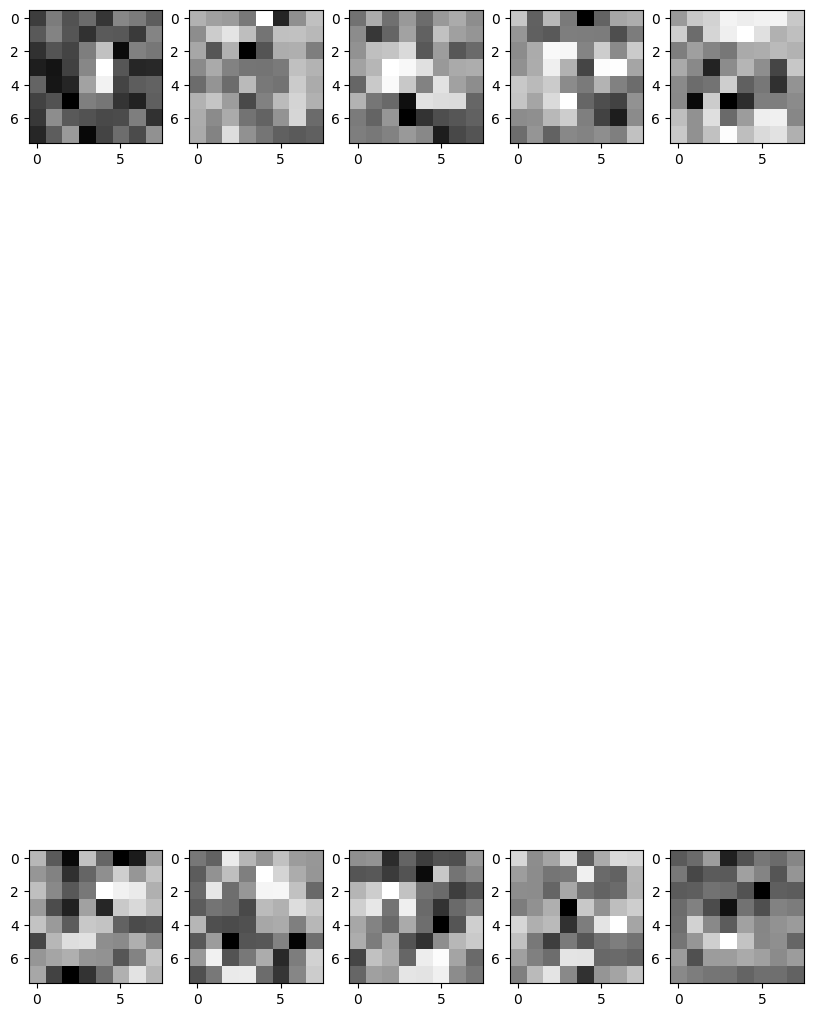

In [85]:
# YOUR CODE HERE
weights = model.linear.weight

def plot_weights(weight):
    h = int(math.sqrt(weight.shape[1]))
    fig, ax = plt.subplots(2, weight.shape[0]//2, figsize=(10, 20))
    for i in range(weight.shape[0]//2):
        im1 = weight[i].reshape(h, h)
        im2 = weight[i+weight.shape[0]//2].reshape(h, h)
        ax[0, i].imshow(im1.detach().numpy(), cmap="Greys")
        ax[1, i].imshow(im2.detach().numpy(), cmap="Greys")
    return fig, ax
        
fig, ax = plot_weights(weights);

#### Optional I: Training with different augmentation strategies

Repeat the same process described above, but using different augmentation strategy, namely:
- Apply a central (vertical or horizontal, one only or both) flip to images in the training dataset;
- Apply random translations to images in the training dataset, bound by an arbitrary maximum;

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.


#### Optional II: Testing for the invariance of the learned representation

Test that the internal representation produced by the weights learned under data augmentation is indeed invariant to the same transformation used for data augmentation. You may follow the guidance given in [this notebook](AdvML_UniTS_2024_Lab_04bis_FCN_Invariance.ipynb).
